In [1]:
import tensorflow as tf
from keras import layers
from keras.models import Model, Sequential
from keras import backend as K
from sklearn.metrics import mean_squared_error
from skimage.measure import compare_ssim as SSIM
import keras
import numpy as np
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
_optimizer = Adam(0.0002, 0.5)
from keras import losses

# from tensorflow.keras import layers
# from tensorflow.keras.models import Model
import cv2
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
def load_imgs(path, number, train_type):
    result=np.empty((number, 64, 64, 3), dtype="float64")
    for i in range(number):
        I = cv2.imread(path + "{:05}_{}.jpeg".format(i+1, train_type))
        result[i, :, :, :] = I[4:-4, 4:-4, :]
    return result/result.max()

In [3]:
'''load images, parse test/validation set'''

dataNum = 4000
dataPath = "testcase_mass/"
x1 = load_imgs(dataPath, dataNum, 1)
x2 = load_imgs(dataPath, dataNum, 2)
y = load_imgs("testcase_mass/", dataNum, 0)
#y = y[:, 8:-8, 8:-8, :]
mask1 = load_imgs(dataPath, dataNum, 4)
#mask1 = mask1[:, 8:-8, 8:-8, :1]
mask1 = mask1[:, :, :, :1]
mask2 = 1-mask1
mask = np.concatenate((mask1, mask2), axis = 3)

x_train1, x_test1, x_train2, x_test2, y_train, y_test, mask_train, mask_test = train_test_split(
    x1, x2, y, mask, test_size=0.25)

In [4]:
def encoder_block(x, _filters, _kernel_size, _strides):
    y = layers.Conv2D(filters = _filters, kernel_size = _kernel_size, 
                      strides = _strides, padding="same",
                      kernel_initializer = keras.initializers.RandomNormal(stddev=0.02))(x)
    y = layers.BatchNormalization(momentum = 0.9, epsilon=1e-5)(y)
    y = layers.ReLU()(y)
    return y

In [5]:
def encoder_net(y):
    y = encoder_block(y, 64, (5, 5), (2, 2))
    y = encoder_block(y, 128, (5, 5), (2, 2))
    y = encoder_block(y, 64, (5, 5), (2, 2))
    y = encoder_block(y, 32, (5, 5), (2, 2))
    y = layers.Flatten()(y)
#     y = layers.Dense(256, 
#                      kernel_initializer = keras.initializers.RandomNormal(stddev=0.02))(y)
#     y = layers.BatchNormalization(momentum = 0.9, epsilon=1e-5)(y)
#     y = layers.ReLU()(y)
    return y

In [6]:
def decoder_block(x, _filters, _kernel_size, _strides):
    y = layers.Conv2DTranspose(filters = _filters, kernel_size = _kernel_size, 
                               strides=_strides, padding="same",
                               kernel_initializer=keras.initializers.RandomNormal(stddev=0.02))(x)
    y = layers.BatchNormalization(momentum = 0.9, epsilon=1e-5)(y)
    y = layers.ReLU()(y)
    return y

In [7]:
def decoder_net(y):
    y = layers.Dense(4*4*32, 
                     kernel_initializer = keras.initializers.RandomNormal(stddev=0.02))(y)

    y = layers.BatchNormalization(momentum = 0.9, epsilon=1e-5)(y)
    y = layers.ReLU()(y)
    y = layers.Reshape((4, 4, 32))(y)
    y = decoder_block(y, 32, (5, 5), (2, 2))
    y = decoder_block(y, 64, (5, 5), (2, 2))
    #print(y._keras_shape)
    y = decoder_block(y, 32, (5, 5), (2, 2))
    
    y = decoder_block(y, 32, (5, 5), (2, 2))
    y = layers.Conv2D(filters = 2, kernel_size = (5, 5), padding = "same",
                      activation="tanh",
                      kernel_initializer = keras.initializers.RandomNormal(stddev=0.02))(y)
    y = layers.Softmax(axis = -1)(y)
    return y

In [8]:
def fusionnet(inTensor1, inTensor2):
    out1 = encoder_net(inTensor1)
    out2 = encoder_net(inTensor2)
    x = layers.Concatenate(axis = -1)([out1, out2])
    y = decoder_net(x)
    return y

In [9]:
def fusionnetPos(y):
    y, inTensor1, inTensor2 = y
#     # crop the input images to the same size as network output.
#     inCrop1 = layers.Cropping2D(cropping=((8, 8), (8, 8)))(inTensor1)
#     inCrop2 = layers.Cropping2D(cropping=((8, 8), (8, 8)))(inTensor2)
    y1 = y[:, :, :, :1]
    y2 = y[:, :, :, 1:]
    y1 = K.tile(y1, [1, 1, 1, 3])
    y2 = K.tile(y2, [1, 1, 1, 3])
    y1 = layers.Multiply()([inTensor1, y1])
    y2 = layers.Multiply()([inTensor2, y2])
    y = layers.Add()([y1, y2])
    return y

In [10]:
img1 = layers.Input(shape=(64, 64, 3))
img2 = layers.Input(shape=(64, 64, 3))
intermed = fusionnet(img1, img2) # intermed: mask layer

pred = layers.Lambda(fusionnetPos)([intermed, img1, img2])

In [11]:
'''2 outputs: 'pred' for GAN loss and 'intermed' for mask loss'''
generator = Model(inputs = [img1, img2], outputs = [pred, intermed])
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   4864        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 32, 64)   4864        input_2[0][0]                    
__________________________________________________________________________________________________
batch_norm

In [12]:
'''tv_loss: designed constraint on mask. WORKS NOT WELL.'''
def tv_loss(y_true, y_pred):
    lambda_mse = 1
    #mapping = tf.cast(y_pred > 0.5, y_pred.dtype)
    #loss = tf.reduce_mean(tf.image.total_variation(mapping))

#     mapping = 0.25 - tf.square(y_pred-0.5) # 0.25-(x-0.5)^2
#     sigma = 0.2
#     mu = 0.5
#     mapping = tf.exp(-0.5*tf.square((y_pred - mu)/sigma))
    mapping = tf.square(y_pred)*tf.square(y_pred-1)/(tf.square(y_pred-0.5)+0.25)
    loss = (1-lambda_mse)*tf.reduce_mean(mapping) + lambda_mse*tf.reduce_mean(tf.square(y_true-y_pred))
    return loss

In [13]:
# '''train on generator using MSE of pred & mask.'''

# lambda_tv = 0
# generator.compile(loss=[losses.mean_squared_error, tv_loss], loss_weights=[1, lambda_tv], optimizer= _optimizer)
# generator.fit([x_train1, x_train2], [y_train, mask_train], batch_size=64, epochs=20)

# prediction, a = generator.predict([x_test1[:100, :, :, :], x_test2[:100, :, :, :]])
# get_layer_output = K.function([generator.layers[0].input, generator.layers[1].input],
#                                   [generator.layers[-2].output])

# layer_output = np.array(get_layer_output([x_test1[:100, :, :, :], x_test2[:100, :, :, :]])[0])

In [14]:
# imgIdx = 11
# fig=plt.figure(figsize=(12, 12))
# columns = 6
# rows = 1
# fig.add_subplot(rows, columns, 1)
# plt.imshow(x_test1[imgIdx, :, :, :])
# fig.add_subplot(rows, columns, 2)
# plt.imshow(x_test2[imgIdx, :, :, :])
# fig.add_subplot(rows, columns, 3)
# plt.imshow(mask_test[imgIdx, :, :, 0])
# fig.add_subplot(rows, columns, 4)
# plt.imshow(layer_output[imgIdx, :, :, 0])
# fig.add_subplot(rows, columns, 5)
# plt.imshow(prediction[imgIdx, :, :, :])
# fig.add_subplot(rows, columns, 6)
# plt.imshow(y_test[imgIdx, :, :, :])
# plt.show()

# #fig.savefig(dataPath+"results/{}.png".format(lambda_mse))

# ssimList = []
# for imgIdx in range(1, 100):
#     ssim = SSIM(y_test[imgIdx, :, :, :], prediction[imgIdx, :, :, :], data_range=1, multichannel=True)
#     ssimList.append(ssim)
#     #print(ssim)
# plt.hist(ssimList, bins = 20)
# ssimArr = np.array(ssimList)
# print(ssimArr.mean())
# print(ssimArr.std())
# #plt.savefig(dataPath+"results/{}_{:.3f}_{:.3f}.png".format(lambda_mse, ssimArr.mean(), ssimArr.std()))

In [15]:
def dis_block(x, _filters, _strides, bn = True):
    y = layers.Conv2D(filters = _filters, kernel_size = (5, 5), strides = _strides, 
                      padding='same')(x)
    if bn:
        y = layers.BatchNormalization(momentum = 0.9, epsilon=1e-5)(y)

    y = layers.LeakyReLU(alpha=0.2)(y)
    return y

In [16]:
def disnet(x):
    y = dis_block(x, 32, (1, 1), bn = False)
    y = dis_block(y, 128, (2, 2))
    y = dis_block(y, 256, (2, 2))
    y = dis_block(y, 256, (2, 2))
    y = layers.Flatten()(y)
    
#     y = layers.Dense(512,
#                     kernel_initializer = keras.initializers.RandomNormal(stddev=0.02))(y)
#     y = layers.BatchNormalization(momentum = 0.9, epsilon=1e-5)(y)
#     y = layers.LeakyReLU(alpha=0.2)(y)
    
    y = layers.Dense(1, activation='sigmoid', 
                    kernel_initializer = keras.initializers.RandomNormal(stddev=0.02))(y)
    return y

In [17]:
dis_input = layers.Input(shape=(64, 64, 3))
dis_output = disnet(dis_input)
discriminator = Model(inputs = dis_input, outputs = dis_output)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 32)        2432      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 128)       102528    
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 256)       819456    
__________

In [18]:
# discriminator.compile(loss='mse', optimizer= _optimizer)
# y_fake = generator.predict([x_train1, x_train2])
# dis_input = np.concatenate((y_fake, y_train), axis = 0)
# label = np.append(np.zeros((y_fake.shape[0], )), np.ones((y_train.shape[0], )))

# for e in range(20):
#     discriminator.fit(dis_input, label)

# label = discriminator.predict(x_test1[:, 8:-8, 8:-8, :])
# print(np.sum(label < 0.5))
# print(label)

In [ ]:
def gannet(x):
    img1, img2 = x
    pred, intermed = generator([img1, img2])
    prob = discriminator(pred)
    discriminator.trainable = False
    return (prob, intermed)

In [ ]:
prob, intermed = gannet([img1, img2])
gan = Model(inputs = [img1, img2], outputs= [prob, intermed])
gan.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 [(None, 64, 64, 3),  1616930     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            2582017     model_1[1][0]                    
Total para

In [ ]:
# prediction = gan.predict([x1, x2])
# mask = prediction[1]
# plt.imshow(mask[6, :, :, 0])
# mask_tensor = tf.convert_to_tensor(mask)
# tv = tf.image.total_variation(mask_tensor)
# sess = tf.Session()
# loss = tv.eval(session=sess)

# print(loss[:10]/32/32/2)

In [ ]:
def plot_loss(losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.figure(figsize=(10,8))
    plt.plot(losses["d"], label='discriminitive loss')
    plt.plot(losses["g"], label='generative loss')
    plt.legend()
    plt.show()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

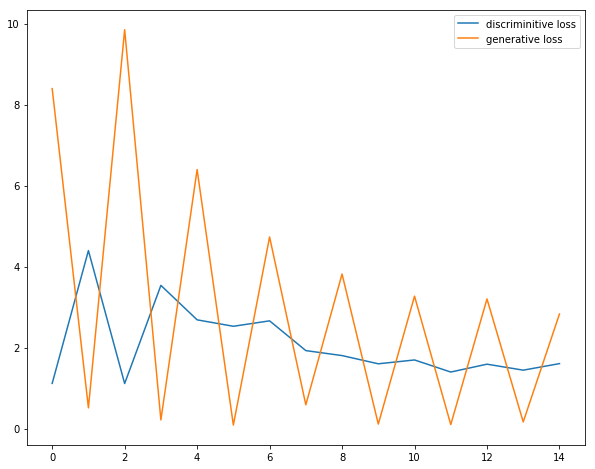

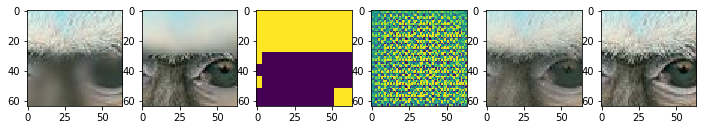

 17%|█▋        | 17/100 [04:49<35:04, 25.36s/it]

In [ ]:
epoch = 100
batchSize = 64
losses = {"d":[], "g":[]}
for e in tqdm(range(epoch)):
    rand_idx = np.random.randint(0, x_train1.shape[0], size = batchSize)
    img_batch1 = x_train1[rand_idx, :, :, :]
    img_batch2 = x_train2[rand_idx, :, :, :]
    mask_batch = mask_train[rand_idx, :, :, :]
    y_batch = y_train[np.random.randint(0, y_train.shape[0], size = batchSize), :, :, :]
    img_fake = generator.predict([img_batch1, img_batch2])[0]
    img_valid = y_batch
    dis_input = np.concatenate((img_fake, img_valid), axis = 0)
    label = np.append(np.zeros((batchSize, )), 1.0*np.ones((batchSize, )))
    
    discriminator.trainable = True
    discriminator.compile(loss='binary_crossentropy', optimizer=_optimizer)
    d_loss = discriminator.train_on_batch(dis_input, label)
    losses["d"].append(d_loss)
    
    gan_label = np.ones((batchSize,))
    discriminator.trainable = False
    gan.compile(loss = ['binary_crossentropy', tv_loss], loss_weights=[1, 0], optimizer=_optimizer)

    g_loss = gan.train_on_batch([img_batch1, img_batch2], [gan_label, mask_batch])
    losses["g"].append(g_loss[1])
    
    if e % 5 == 4:
        plot_loss(losses)

        imgIdx = 12
        prediction = generator.predict([x1[imgIdx:imgIdx+1, :, :, :], x2[imgIdx:imgIdx+1, :, :, :]])[0]
        #ssim = SSIM(y[imgIdx, :, :, :], prediction[0, :, :, :], data_range=prediction[0, :, :, :].max() - prediction[0, :, :, :].min(), multichannel=True)
        #print(ssim)
        
        get_layer_output = K.function([generator.layers[0].input, generator.layers[1].input],
                                          [generator.layers[-2].output])

        layer_output = np.array(get_layer_output([x1[imgIdx:imgIdx+1, :, :, :], x2[imgIdx:imgIdx+1, :, :, :]])[0])

        fig=plt.figure(figsize=(12, 12))
        columns = 6
        rows = 1
        fig.add_subplot(rows, columns, 1)
        plt.imshow(x1[imgIdx, :, :, :])
        fig.add_subplot(rows, columns, 2)
        plt.imshow(x2[imgIdx, :, :, :])
        fig.add_subplot(rows, columns, 3)
        plt.imshow(mask[imgIdx, :, :, 0])
        fig.add_subplot(rows, columns, 4)
        plt.imshow(layer_output[0, :, :, 0])
        fig.add_subplot(rows, columns, 5)
        plt.imshow(prediction[0, :, :, :])
        fig.add_subplot(rows, columns, 6)
        plt.imshow(y[imgIdx, :, :, :])
        plt.show()
        fig.savefig(dataPath+"results/aegan_{}.png".format(e))

In [ ]:
prediction = generator.predict([x_test1[:100, :, :, :], x_test2[:100, :, :, :]])
get_layer_output = K.function([generator.layers[0].input, generator.layers[1].input],
                                  [generator.layers[-2].output])

layer_output = np.array(get_layer_output([x_test1[:100, :, :, :], x_test2[:100, :, :, :]])[0])

In [ ]:
# np.save('x_test1.npy', x_test1)
# np.save('x_test2.npy', x_test2)
# np.save('y_test.npy', y_test)
# np.save('prediction.npy', prediction[0])
# np.save('layer_output.npy', layer_output)
# np.save('mask_test.npy', mask_test)

In [ ]:
# ssimList = []
# ssimList1 = []
# ssimList2 = []
# ada = 999
for imgIdx in range(1, 100):
#     ssim = SSIM(y_test[imgIdx, :, :, :], prediction[0][imgIdx, :, :, :], data_range=1, multichannel=True)
#     ssimList.append(ssim)
#     ssim1 = SSIM(y_test[imgIdx, :, :, :], x_test1[imgIdx, 8:-8, 8:-8, :], data_range=1, multichannel=True)
#     ssimList1.append(ssim)
#     ssim2 = SSIM(y_test[imgIdx, :, :, :], x_test2[imgIdx, 8:-8, 8:-8, :], data_range=1, multichannel=True)
#     ssimList2.append(ssim)
#     print(ssim1)
#     print(ssim2)
#     print(ssim)
#    imgIdx = 312
    fig=plt.figure(figsize=(12, 12))
    columns = 6
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(x_test1[imgIdx, 8:-8, 8:-8, :])
    fig.add_subplot(rows, columns, 2)
    plt.imshow(x_test2[imgIdx, 8:-8, 8:-8, :])
    fig.add_subplot(rows, columns, 3)
    plt.imshow(mask_test[imgIdx, :, :, 0])
    fig.add_subplot(rows, columns, 4)
    plt.imshow(prediction[0][imgIdx, :, :, :])
    fig.add_subplot(rows, columns, 5)
    plt.imshow(y_test[imgIdx, :, :, :])
    fig.add_subplot(rows, columns, 6)
    plt.imshow(layer_output[imgIdx, :, :, 0])
    plt.show()
    fig.savefig(dataPath+"results/{}.png".format(imgIdx))

In [ ]:
#plt.hist(ssimList, bins = 20)

In [ ]:
# generator.save('generator.h5')